# Aula prática - Similarity 

##  Siamese Network with contrastive loss
Objetivo: implementar uma rede siamesa simples para aprender embeddings de similaridade entre imagens.

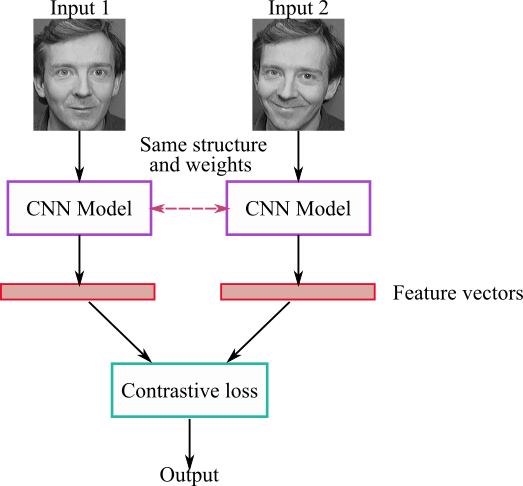

In [1]:
import os
import pandas as pd
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

np.random.seed(0)

## Dataset

* Conjunto de dados público do Vision and Robotics Group, do Departamento de Engenharia da Universidade de Cambridge.

* Existem dez imagens diferentes de cada um dos 40 indivíduos distintos.

* Para alguns indivíduos, as imagens foram tiradas em momentos diferentes, variando a iluminação, expressões faciais (olhos abertos/fechados, sorrindo/não sorrindo) e detalhes faciais (óculos/sem óculos).

* Todas as imagens foram tiradas com os indivíduos em posição ereta e frontal (com tolerância para algum movimento lateral).

* Os arquivos estão no formato PGM.

* O tamanho de cada imagem é 92x112 pixels, com 256 níveis de cinza por pixel.

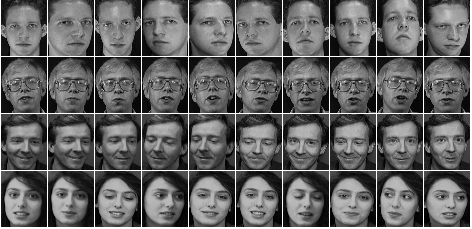

### Criando o DataSet
Seu objetivo é construir a função `generate_pairs(images_dict, num_pairs=1000)`, que deve retornar **duas listas**:

* `genuine_pairs`: pares de **imagens da mesma pessoa** → rótulo `1`
* `impostor_pairs`: pares de **imagens de pessoas diferentes** → rótulo `0`

Cada elemento dessas listas deve ter o formato:

```python
(img_path_1, img_path_2, label)
```

#### Requisitos da função

1. **Distribua o número de pares de forma balanceada** entre os sujeitos (para evitar que pessoas com mais imagens dominem o dataset).
   * Dica: você pode calcular `num_pairs // len(subjects)` para estimar quantos pares por pessoa gerar.

2. **Evite duplicatas**.

   * Por exemplo, `(img1, img2)` e `(img2, img1)` devem ser considerados o mesmo par.
   * A função `itertools.combinations(imgs, 2)` pode ajudar aqui.

3. **Gere pares genuínos** (mesmo sujeito):

   * Selecione aleatoriamente duas imagens **diferentes** da mesma pessoa.

4. **Gere pares impostores** (sujeitos diferentes):

   * Escolha duas pessoas distintas e selecione uma imagem de cada uma.

5. **Mantenha o dataset balanceado**.

   * Tente gerar quantidades semelhantes de pares genuínos e impostores.
   * Dica: você pode selecionar aleatoriamente elementos da maior lista de forma que o novo tamanho seja igual o da menor lista.  

6. **Retorne duas listas:**

   ```python
   return genuine_pairs, impostor_pairs
   ```

O que queremos, então, são duas listas como representado abaixo:


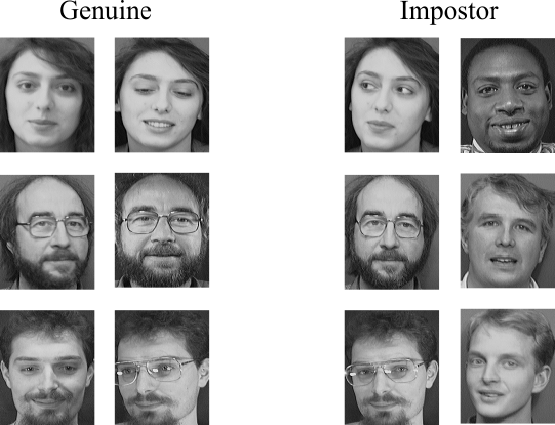

In [41]:
def read_image_paths(root_path):
    # Dicionário para armazenar as imagens de cada pessoa
    images_dict = {}
    
    # Percorrer todas as pastas de sujeitos (s1, s2, ..., s40)
    for subject in os.listdir(root_path):
        subject_path = os.path.join(root_path, subject)
        
        if os.path.isdir(subject_path):
            # Listar todos os arquivos de imagem dentro da pasta do sujeito
            images = [os.path.join(subject_path, img) for img in os.listdir(subject_path) if img.endswith('.pgm')]
            images_dict[subject] = images
            
    return images_dict

def generate_pairs(images_dict, num_pairs=1000):
    """Gera pares genuínos e impostores balanceados, evitando duplicatas."""

    genuine_pairs = []
    impostor_pairs = []
    subjects = list(images_dict.keys())

    #SEU CÓDIGO AQUI

    return genuine_pairs, impostor_pairs


def save_pairs_to_csv(pairs, csv_filename):
    df = pd.DataFrame(pairs, columns=['image1', 'image2', 'label']) # Criar um DataFrame com os pares de imagens
    df.to_csv(csv_filename, index=False) # Salvar o DataFrame como CSV
    print(f"CSV salvo como {csv_filename}")

root_path = "/kaggle/input/att-database-of-faces"
images_dict = read_image_paths(root_path)
all_subjects = list(images_dict.keys())

# Dividir aleatoriamente os sujeitos
train_subjects = np.random.choice(all_subjects, 25, replace=False)
remaining = list(set(all_subjects) - set(train_subjects))
validation_subjects = np.random.choice(remaining, 7, replace=False)
test_subjects = list(set(remaining) - set(validation_subjects))

# Gerar pares
genuine_train, impostor_train = generate_pairs({s: images_dict[s] for s in train_subjects}, num_pairs=10000)
genuine_val, impostor_val = generate_pairs({s: images_dict[s] for s in validation_subjects}, num_pairs=2500)
genuine_test, impostor_test = generate_pairs({s: images_dict[s] for s in test_subjects}, num_pairs=1000)

# Combinar e salvar
for split, (genuine, impostor) in {
    "train": (genuine_train, impostor_train),
    "validation": (genuine_val, impostor_val),
    "test": (genuine_test, impostor_test),
}.items():
    pairs = genuine + impostor
    print(f"{split.capitalize()}: {len(pairs)} pares (balanceados)")
    save_pairs_to_csv(pairs, f"siamese_{split}_pairs.csv")

Train: 0 pares (balanceados)
CSV salvo como siamese_train_pairs.csv
Validation: 0 pares (balanceados)
CSV salvo como siamese_validation_pairs.csv
Test: 0 pares (balanceados)
CSV salvo como siamese_test_pairs.csv


In [29]:
class SiameseDataset(Dataset):
    def __init__(self, csv_file, device, transform=None):
        self.data = pd.read_csv(csv_file)
        self.device = device
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = self.data.iloc[idx, 0]
        img2_path = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 2]

        # Ler as imagens usando torchvision
        img1 = Image.open(img1_path).convert("L")  # L for grayscale
        img2 = Image.open(img2_path).convert("L") # Lê a imagem como um tensor

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # Enviar para o dispositivo (CPU ou GPU)
        img1 = img1.to(self.device)
        img2 = img2.to(self.device)
        label = torch.tensor(label).to(self.device)

        return img1, img2, label

In [30]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Ajuste para o tamanho desejado
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalização para imagens em escala de cinza
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256  

train_dataset = SiameseDataset('/kaggle/working/siamese_train_pairs.csv', device, transform=transform)
validation_dataset = SiameseDataset('/kaggle/working/siamese_validation_pairs.csv', device, transform=transform)
test_dataset = SiameseDataset('/kaggle/working/siamese_test_pairs.csv', device, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [42]:
for img1, img2, label in train_loader:
    print(img1.shape, img2.shape, label.shape)  
    break

torch.Size([256, 1, 100, 100]) torch.Size([256, 1, 100, 100]) torch.Size([256])


Verifique se sua função tem o comportamento esperado visualizando as imagens abaixo. Lembre-se:
* `genuine_pairs`: pares de **imagens da mesma pessoa** → rótulo `1`
* `impostor_pairs`: pares de **imagens de pessoas diferentes** → rótulo `0`

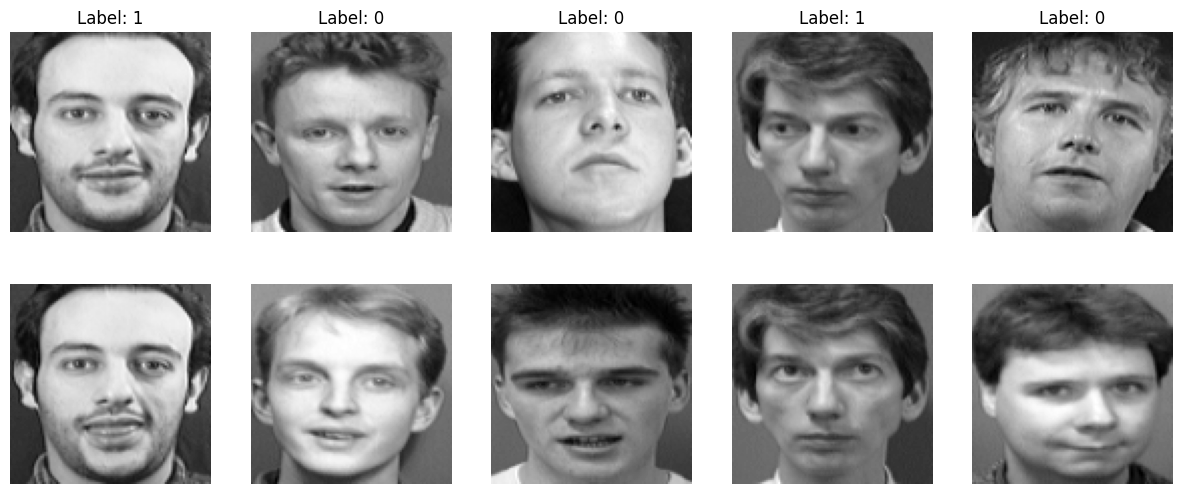

In [43]:
def show_example_pairs(data_loader, num_examples=5):
    for i, (img1, img2, label) in enumerate(data_loader):
        if i >= num_examples:
            break
        
        # Converter os tensores para numpy para visualização
        img1 = img1.cpu().numpy().squeeze(1)
        img2 = img2.cpu().numpy().squeeze(1)

        # Plotar as imagens
        fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))
        for j in range(num_examples):
            axes[0, j].imshow(img1[j], cmap='gray')
            axes[0, j].axis('off')
            axes[1, j].imshow(img2[j], cmap='gray')
            axes[1, j].axis('off')
        
        # Mostrar labels
        for j in range(num_examples):
            axes[0, j].set_title(f'Label: {label[j].item()}')
        
        plt.show()
        break  # Apenas mostrar os primeiros exemplos

# Exibir alguns pares do conjunto de treino
show_example_pairs(train_loader, num_examples=5)

## Criando Siamese Network

Agora que já temos nossos pares de imagens (genuínos e impostores), vamos construir a rede siamesa que aprenderá a distinguir entre pares semelhantes e diferentes.

Uma Siamese Network é um tipo especial de arquitetura que recebe duas entradas e aprende a medir a distância (ou dissimilaridade) entre elas.
O conceito central é que imagens da mesma classe (mesma pessoa) devem gerar representações vetoriais próximas, enquanto imagens de classes diferentes devem gerar representações distantes no espaço de embeddings.

Nossa rede siamesa será composta por duas partes principais:

1. Rede de Extração de Características (BaseNetwork):
    - Ambas as imagens passam por essa mesma CNN, que gera o vetor de embedding de cada imagem.
    - Sugestão: crie um espaço latente de dimensão 16, será suficiente nesse caso.

  
2. Cálculo da Distância (ou Similaridade):
    - Após obter os embeddings output1 e output2, calculamos uma distância vetorial (por exemplo, L1, L2).
    - Essa distância é o que será usada para treinar o modelo com uma função de perda contrastiva.
    - Dica: utilize a função [F.pairwise_distance](https://docs.pytorch.org/docs/stable/generated/torch.nn.PairwiseDistance.html#torch.nn.PairwiseDistance).

 ```python
   distance = F.pairwise_distance(output1, output2)
   ```

In [9]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        #TODO
    
    def forward(self, x):
       # TODO
        return embedding

class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network

    def forward(self, x1, x2):
        # TODO: compute embeddings e distância
        return distance

## Função de Perda

A contrastive loss penaliza pares semelhantes com distância grande e pares diferentes com distância pequena.

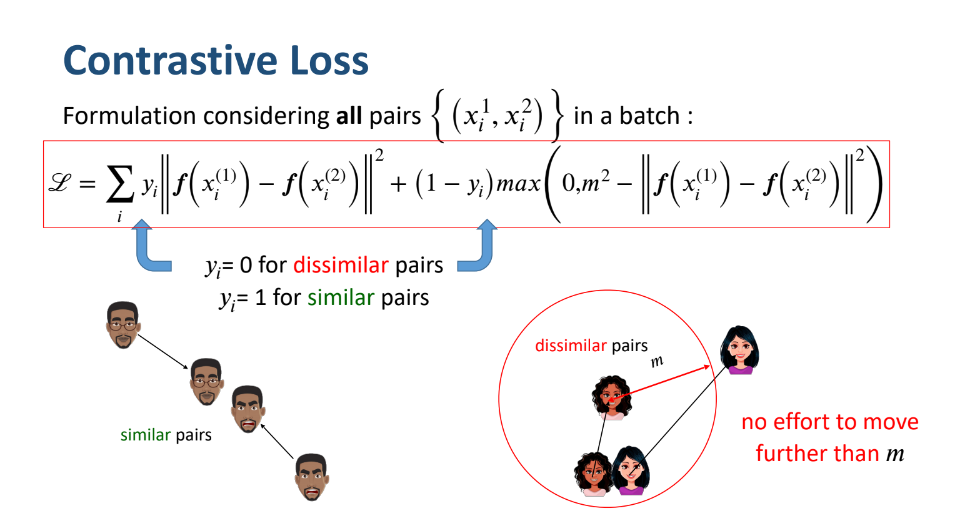

Implemente a função contrastive_loss:

In [44]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    # Loss para pares semelhantes (y_true = 1) e diferentes (y_true = 0)
    # TO DO
    return loss.mean()

O que acontece se escolhermos um valor de margin muito alto?
E se for muito pequeno?

## Treinando o Modelo

Se tudo estiver correto, o código abaixo deve funcionar:

In [12]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    model.train()  # Coloca o modelo em modo de treino

    # Inicializa o dicionário para armazenar as perdas
    history = {
        'train_losses': [],
        'val_losses': []
    }

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Loop de treinamento com barra de progresso
        for i, (img1, img2, label) in enumerate(tqdm(train_loader, desc=f'Treino - Época {epoch + 1}/{num_epochs}', unit='batch')):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass
            output = model(img1, img2)

            # Calcular a perda
            loss = contrastive_loss(label, output, margin = 1)

            # Backward pass e otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Cálculo da perda média para a época
        avg_train_loss = running_loss / len(train_loader)
        history['train_losses'].append(avg_train_loss)  # Adiciona a perda de treinamento ao histórico
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        # Validação
        val_loss = validate_model(model, val_loader, device)
        history['val_losses'].append(val_loss)  # Adiciona a perda de validação ao histórico
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

    print('Treinamento completo')
    return history  # Retorna o dicionário de histórico

def validate_model(model, val_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    running_loss = 0.0

    with torch.no_grad():  # Não calcula os gradientes durante a validação
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output = model(img1, img2)
            loss = contrastive_loss(label, output)
            running_loss += loss.item()

    return running_loss / len(val_loader)  # Retorna a perda média de validação


In [35]:
base_network = BaseNetwork().to(device)
model = SiameseNetwork(base_network).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
history = train_model(model, train_loader, validation_loader, optimizer, num_epochs=2, device=device)

Treino - Época 1/2: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s]


Epoch [1/2], Train Loss: 0.4832
Epoch [1/2], Validation Loss: 0.4730


Treino - Época 2/2: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s]

Epoch [2/2], Train Loss: 0.4520
Epoch [2/2], Validation Loss: 0.4713
Treinamento completo


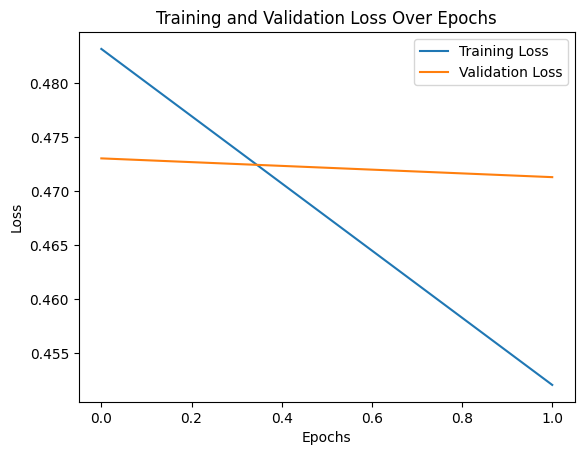

In [36]:
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Testando o Modelo

Para avaliar o modelo calculamos a loss no conjunto de teste e plotamos algumas amostras e suas distâncias no espaço latente:

In [1]:
def test_model(model, test_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação (desativa dropout, etc.)
    running_test_loss = 0.0

    with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass
            output = model(img1, img2)

            # Calcular a perda
            loss = contrastive_loss(label, output)
            running_test_loss += loss.item()

    # Cálculo da perda média no conjunto de teste
    avg_test_loss = running_test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    return avg_test_loss


def plot_test_images(model, test_loader, device, num_pairs=4):
    model.eval()  # Coloca o modelo em modo de avaliação
    fig, axes = plt.subplots(num_pairs, 2, figsize=(5, num_pairs * 2.5))  # Configurar o plot

    with torch.no_grad():  # Desativa gradientes
        count = 0  # Contador para número de pares mostrados
        for img1, img2, label in test_loader:
            if count >= num_pairs:  # Limitar a quantidade de pares
                break

            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass para obter a distância para o batch inteiro
            distances = model(img1, img2)

            # Para cada par no batch
            for j in range(img1.size(0)):
                if count >= num_pairs:
                    break  # Interrompe se já mostramos o número necessário de pares

                # Converter img1 e img2 para o formato correto (removendo a dimensão do batch)
                img1_np = img1[j].cpu().numpy()  # Selecionar a j-ésima imagem no batch
                img2_np = img2[j].cpu().numpy()

                # Plotar as imagens
                axes[count, 0].imshow(img1_np.squeeze(), cmap='gray')
                axes[count, 1].imshow(img2_np.squeeze(), cmap='gray')



                axes[count, 0].set_title(f"Distância: {distances[j].item():.4f} ")
                
                axes[count, 0].axis('off')
                axes[count, 1].axis('off')

                count += 1  # Incrementar contador

    plt.tight_layout()
    plt.show()
    
# Avaliando o modelo no conjunto de teste
test_loss = test_model(model, test_loader, device)
plot_test_images(model, test_loader, device)

## Visualizando o Espaço Latente

Geramos um espaço latente de dimensão n (se você seguiu a minha sugestão, n=16); Para tornar o modelo um pouco mais comprensível podemos visualizar o espaço latente em 2D / 3D usando PCA ou t-SNE para reduzir a dimensionalidade. Escolha uma (ou as duas) técnicas e gere o gráfico do espaço latente.

* Dica: você encontra ambas implementações no sklearn

## Extras

1. Altere o valor de margin na função de perda e veja o que acontece;
2. Testar diferentes métricas de distância (distância L2/L1/similaridade cosseno) e veja como afeta as métricas/espaço latente;
3. Você pode criar um BaseNetwork diferente e comparar os resultados;
4. Qual melhor *threshold* da distância predita pelo modelo para classificar em "mesma pessoa" e "pessoa diferente"?
5. Teste com amostras externas (outra base de dados). O modelo consegue detectar que é a mesma pessoa, dado o limiar escolhido? 